# MOwNiT 

## Laboratorium 3

### Interpolacja

Przed uruchomieniem trzeba zainstalować pakiet:

```julia
Pkg.add("Interpolations")
```

In [1]:
using Pkg
#Pkg.add("Polynomials")
#Pkg.add("Interpolations")

In [2]:
using Plots

In [202]:
# wylosowanie węzłów interpolacji
xs =  1:1:10
ys = [rand() for x in xs]

10-element Array{Float64,1}:
 0.43376696788912517
 0.6917337363247467
 0.8736165043142623
 0.8329946126615875
 0.3756845360391632
 0.9869598500287464
 0.5452017323105307
 0.6872264024578731
 0.14796149945555692
 0.5381165726851449

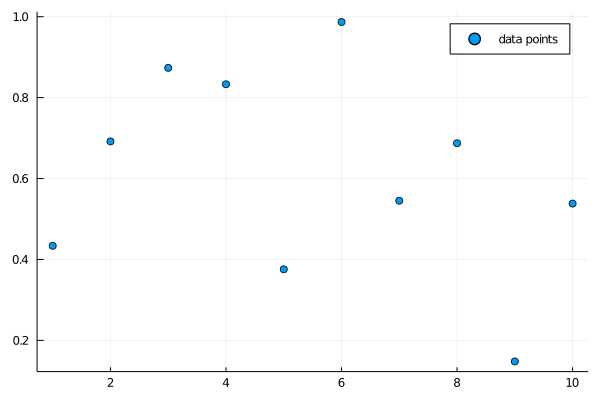

In [203]:
scatter(xs,ys, label="data points")

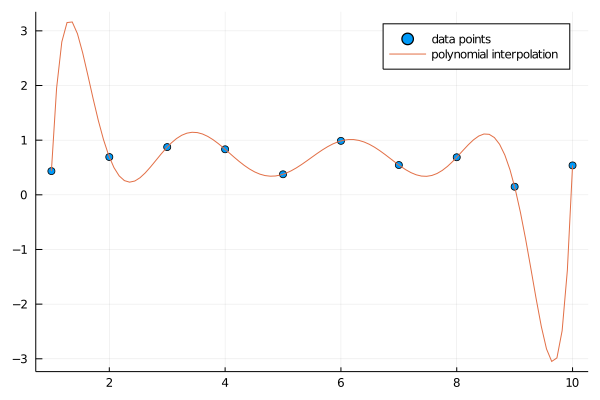

In [204]:
# interpolacja wielomianowa w pakiecie Polynomials
# https://juliamath.github.io/Polynomials.jl/stable/
using Polynomials
f=fit(xs, ys)
plot!(f,  extrema(xs)..., label="polynomial interpolation")

In [249]:
# gęste punkty do rysowania wykresów funkcji interpolujacych
xsf=1:0.01:10

1.0:0.01:10.0

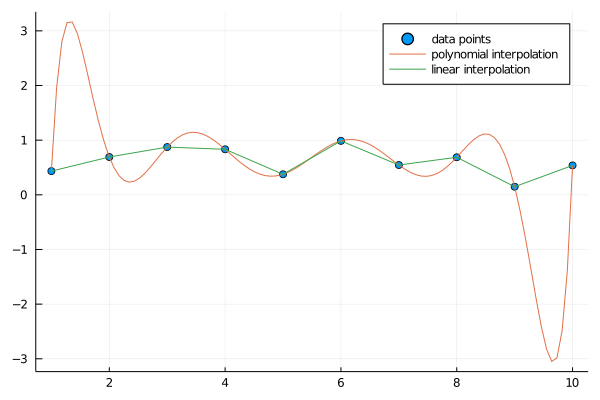

In [250]:
#  interpolacja liniowa z pakietu Interpolations - przykład
using Interpolations
interp_linear = LinearInterpolation(xs, ys)
ysf=[interp_linear(x) for x in xsf]
plot!(xsf,ysf, label="linear interpolation")

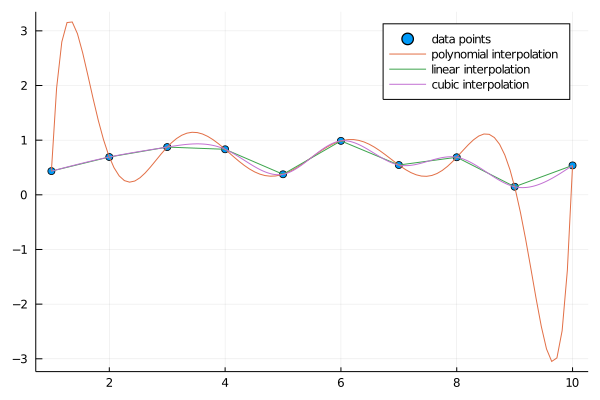

In [251]:
#  interpolacja szescienna 
interp_cubic = CubicSplineInterpolation(xs, ys)
ysf2=[interp_cubic(x) for x in xsf]
plot!(xsf,ysf2, label="cubic interpolation")

In [252]:
#Interpolacja szescienna to BSpline z warunkami brzegowymi Line i OnGrid. 
#Więcej o konfiguracji warunkow brzegowych w
# dokumentacji https://github.com/JuliaMath/Interpolations.jl/blob/master/doc/Interpolations_algebra.pdf
interp_cubic

10-element extrapolate(scale(interpolate(OffsetArray(::Array{Float64,1}, 0:11), BSpline(Cubic(Line(OnGrid())))), (1:1:10,)), Throw()) with element type Float64:
 0.4337669678891251
 0.6917337363247467
 0.8736165043142623
 0.8329946126615875
 0.3756845360391632
 0.9869598500287464
 0.5452017323105307
 0.6872264024578731
 0.14796149945555692
 0.5381165726851449

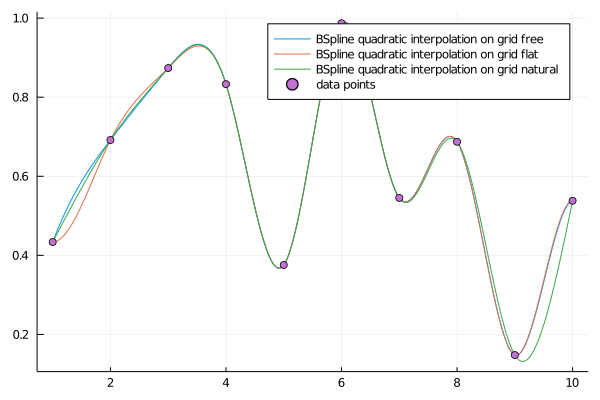

In [253]:
# Przyklad konfiguracji  BSpline-ów
itp = interpolate(ys, BSpline(Cubic(Free(OnGrid()))))
ysf3=[itp(x) for x in xsf]
plot(xsf,ysf3, label="BSpline quadratic interpolation on grid free")
itp = interpolate(ys, BSpline(Cubic(Flat(OnGrid()))))
ysf3=[itp(x) for x in xsf]
plot!(xsf,ysf3, label="BSpline quadratic interpolation on grid flat")
itp = interpolate(ys, BSpline(Cubic(Natural(OnGrid()))))
ysf3=[itp(x) for x in xsf]
plot!(xsf,ysf3, label="BSpline quadratic interpolation on grid natural")

scatter!(xs,ys, label="data points")


### Zadania
1. Napisać własną implementację interpolacji wielomianowej stosując wprost wzór na wielomian interpolacyjny  Lagrange'a .  Przetestować swoją implementację na wylosowanych węzłach interpolacji w wybranym przedziale. Narysować wykres wielomianu interpolacyjnego w tym przedziale wraz z wezlami interpolacji. <b>(1 pkt)</b>

1. Zrobic to samo dla metody  Newtona (metoda ilorazów róznicowych).Narysować wykres wielomianu interpolacyjnego otrzymanego metodą Newtona dla tych samych danych, co w poprzednim punkcie. Zadbać o to, żeby ilorazy wyliczać tylko raz dla danego zbioru wezłow interpolacji, według schematu z pakietu Interpolations http://juliamath.github.io/Interpolations.jl/stable/interpolations/ : 
   1. napisać funkcję `NewtonInterpolation`, która wylicza ilorazy różnicowe i zwraca "obiekt interpolacyjny" `newt`
   1. napisać funkcję która wylicza wartość wielomianu dla obiektu `newt` w punkcie x za pomocą  <b>schematu Hornera dla postaci Newtona </b> <b>(2 pkt)</b>

1. Zastosowac interpolację wielomianową z pakietu Polynomials  do tych samych danych, co w poprzednich punktach. Porównać wszystkie 3 wyniki interpolacji wielomianowej na jednym wykresie. Co zauważamy? Dlaczego? <b>(1 pkt)</b>

1. Porownać  metody poprzez pomiar czasu wykonania dla zmiennej ilości węzłow interpolacji. Uwaga: dodatkowo, dla metody Newtona i pakietu Polynomials należy osobno zmierzyć czas wyliczania wielomianu i osobno czas wyliczania wartości w punkcie. Dokonac pomiaru 10 razy i policzyc wartość średnią oraz oszacować bład pomiaru za pomoca odchylenia standardowego.  Jako narzedzie do analizy danych użyć Julia DataFrames. <b>(2 pkt)</b>

1. Zaimplementować algorytm Neville’a i sprawdzić (dla kilku wybranych punktów), czy daje te same wartości wielomianu co wybrana interpolacja wielomianowa.<b>(1 pkt)</b>

1. Poeksperymentować z  interpolacją funkcjami sklejanymi (minimum dwie różne funkcje sklejane),  narysować wykresy i porównać z wykresami interpolacji wielomianowej. <b>Zademonstrować  efekt Rungego</b> <b>(1 pkt)</b>. 



# Zadanie 1 - Wielomian Lagrange'a

In [505]:
function LagrangeInterpolation(xs,ys)
    function Lagrange(x)
        n = length(x)
        output = zeros(n)
        if(n == 1)
            output = 0
        end
        for k = 1:n
            N = length(xs)
            LagrangePolynomials = ones(N)
            for i in 1:N  
                for j in [1:i-1;i+1:N]     
                    LagrangePolynomials[i] = LagrangePolynomials[i].*(x[k]-xs[j])./(xs[i]-xs[j])
                end
            end
            n == 1 ? output = sum(LagrangePolynomials.*ys) : output[k] = sum(LagrangePolynomials.*ys)
        end
        return output
    end
    return Lagrange
end

LagrangeInterpolation (generic function with 1 method)

## Zadanie 2 - Metoda Newtona

In [532]:
function difference(xs,ys)
    n = length(xs)
    a = Array{Float64}(undef,n)
    for i in 1:n
        a[i] = ys[i]
    end
    for j in 2:n
        for i in reverse(collect(j:n))
            a[i]=(a[i]-a[i-1])/(xs[i]-xs[i-(j-1)])
        end
    end
    return a
end

difference (generic function with 1 method)

In [520]:
function NewtonInterpolation(X,Y)
    function newt(x)
        n = length(X)
        a = difference(X,Y)
        res = a[1]
        polynomial = 1.0
        for j in 1:(n-1)
            polynomial = polynomial *(x-X[j])
            res = res + a[j+1]*polynomial
        end
        return res
    end
    return newt
end

NewtonInterpolation (generic function with 2 methods)

In [521]:
a = [1.0,2.0,3.0]
b = [5.0,10.0,15.0]
NewtonInterpolationfunc = NewtonInterpolation([1.765,1.760,1.755,1.750],[0.92256,0.92137,0.92021,0.91906])
NewtonInterpolationfunc(1.761)

0.92160496

In [522]:
a = [1.0,2.0,3.0]
b = [5.0,10.0,15.0]
NewtonInterpolationfunc = NewtonInterpolation([1.0,2.0,3.0],[5.0,10.0,15.0])

(::var"#newer#5"{Array{Float64,1},Array{Float64,1}}) (generic function with 1 method)

In [523]:
NewtonInterpolationfunc(1.0)

5.0

In [524]:
A = 1:1:10
B = [rand() for a in A]

10-element Array{Float64,1}:
 0.1683735595675646
 0.5069463729271411
 0.157481059817562
 0.6718166041083047
 0.3899944186291717
 0.19840934955067824
 0.19171887116680963
 0.7710292854425922
 0.8097330635847384
 0.6603930113950502

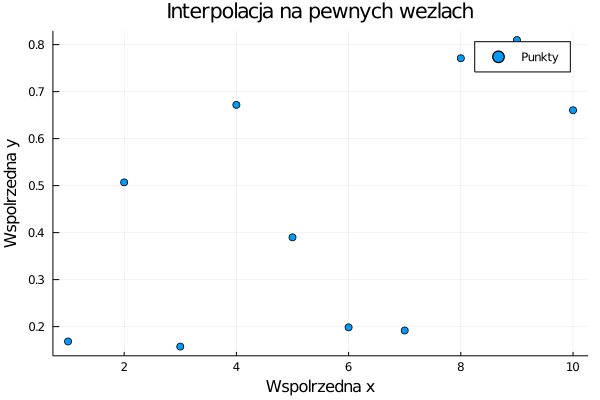

In [525]:
scatter(A,B,label = "Punkty",xlabel = "Wspolrzedna x",ylabel = "Wspolrzedna y",title = "Interpolacja na pewnych wezlach")

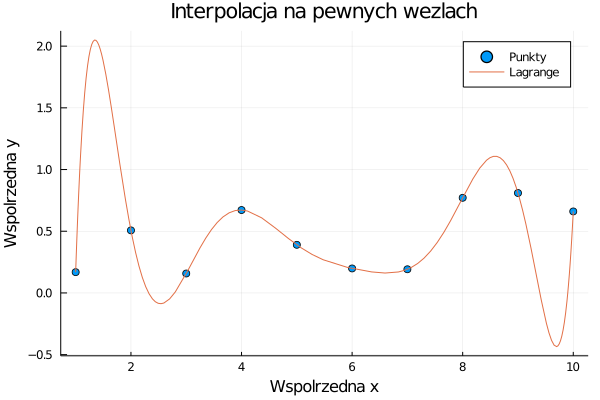

In [526]:
L = LagrangeInterpolation(A,B)
plot!(L,extrema(A)...,label = "Lagrange")

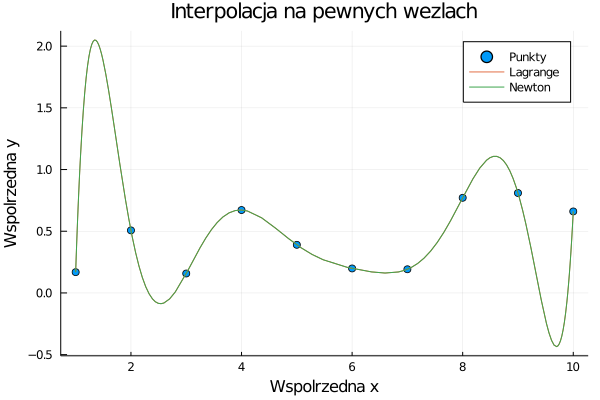

In [527]:
N = NewtonInterpolation(A,B)
plot!(N,extrema(A)...,label = "Newton")

## Zadanie 3

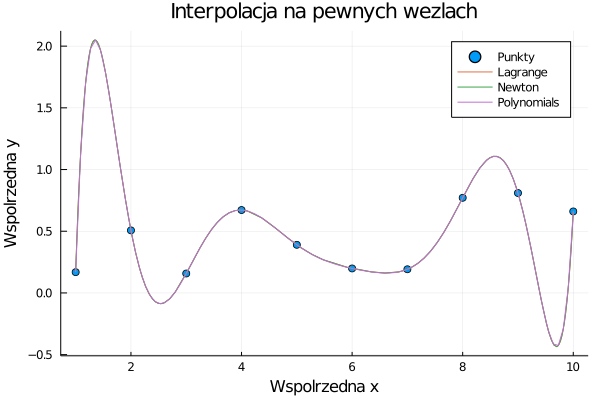

In [528]:
f=fit(A, B)
plot!(f,  extrema(A)..., label="Polynomials")

Wniosek - Na końcach węzłów interpolacji następuje utworzenie się wybrzuszeń niezależnie od wybranej metody interpolacji. Każda metoda zachowuje się tak samo z delikatnymi różnicami na końcach węzłów

## Zadanie 4

In [398]:
using DataFrames
using Statistics

In [399]:
amount = zeros(0)
times = zeros(0)
timesNewtonPolynomial = zeros(0)
timesNewtonValue = zeros(0)
timesPolynomialsPolynomial = zeros(0)
timesPolynomialValue = zeros(0)
for i in 1:500
    pointsx = zeros(0)
    pointsy = zeros(0)
    for k in 1:i
        append!(pointsx,rand())
        append!(pointsy,rand())
    end
    for j in 1:10
        append!(amount,i)
        N = NewtonInterpolation(pointsx,pointsy)
        f = fit(pointsx,pointsy)
        append!(timesNewtonPolynomial,@elapsed NewtonInterpolation(pointsx,pointsy))
        append!(timesNewtonValue,@elapsed N(rand()))
        append!(timesPolynomialsPolynomial,@elapsed fit(pointsx,pointsy))
        append!(timesPolynomialValue,@elapsed f(rand()))
        append!(times,@elapsed (LagrangeInterpolantGenerator(pointsx,pointsx)))
    end
end

In [400]:
X = zeros(0)
Y = zeros(0)
for i in 1:500
    append!(X,i)
    append!(Y,i)
end
t = fit(X,Y)

Polynomial(1.0*x)

## Osiągnięte rezultaty dla pakietu Polynomials

In [401]:
PolynomialPol = DataFrame(amount = amount, timesPolynomial = timesPolynomialsPolynomial,timesValues = timesPolynomialValue)

,amount,timesPolynomial,timesValues
,Float64,Float64,Float64
1,1.0,1.1e-6,3.0e-6
2,1.0,7.99e-7,2.0e-7
3,1.0,3.0e-7,1.0e-7
4,1.0,3.0e-7,1.0e-7
5,1.0,6.0e-7,1.0e-7
6,1.0,8.0e-7,1.0e-7
7,1.0,3.0e-7,1.0e-7
8,1.0,5.0e-7,1.0e-7
9,1.0,5.0e-7,1.0e-7


### Rezultaty dla czasu tworzenia wielomianu

In [468]:
gdf = groupby(PolynomialPol,:amount)
gdf = combine(gdf,:timesPolynomial => mean,:timesPolynomial => std)

,amount,timesPolynomial_mean,timesPolynomial_std
,Float64,Float64,Float64
1,1.0,5.499e-7,2.75782e-7
2,2.0,4.2e-7,1.81353e-7
3,3.0,4.802e-7,1.68748e-7
4,4.0,4.701e-7,1.41994e-7
5,5.0,4.6e-7,1.71011e-7
6,6.0,5.301e-7,1.88839e-7
7,7.0,5.4e-7,1.3499e-7
8,8.0,5.101e-7,9.94322e-8
9,9.0,6.698e-7,1.82781e-7


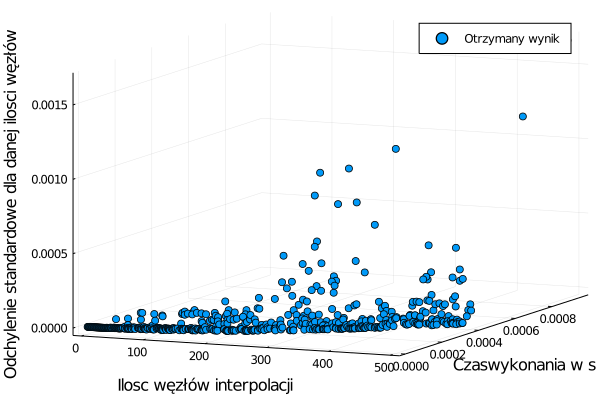

In [469]:
scatter(gdf.amount,gdf.timesPolynomial_mean,gdf.timesPolynomial_std,label = "Otrzymany wynik",xlabel = "Ilosc węzłów interpolacji",ylabel = "Czaswykonania w s",zlabel = "Odchylenie standardowe dla danej ilosci węzłów")

### Rezultaty dla czasu uzyskania wartości

In [465]:
gdf = groupby(PolynomialPol,:amount)
gdf = combine(gdf,:timesValues => mean,:timesValues => std)

,amount,timesValues_mean,timesValues_std
,Float64,Float64,Float64
1,1.0,4.0e-7,9.14087e-7
2,2.0,9.0e-8,3.16228e-8
3,3.0,9.0e-8,5.67646e-8
4,4.0,1.0e-7,4.71405e-8
5,5.0,1.0e-7,4.71405e-8
6,6.0,1.0e-7,4.71405e-8
7,7.0,9.0e-8,3.16228e-8
8,8.0,9.0e-8,3.16228e-8
9,9.0,9.01e-8,3.16595e-8


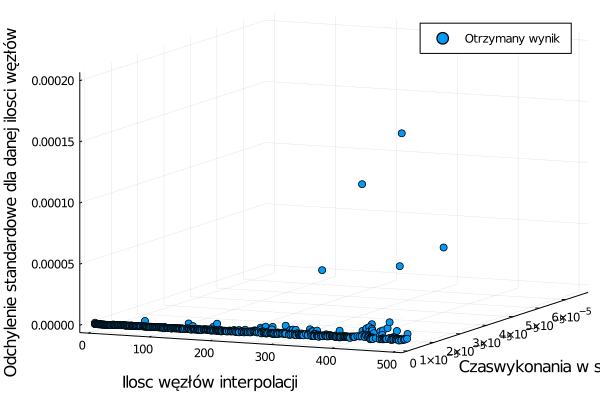

In [466]:
scatter(gdf.amount,gdf.timesValues_mean,gdf.timesValues_std,label = "Otrzymany wynik",xlabel = "Ilosc węzłów interpolacji",ylabel = "Czaswykonania w s",zlabel = "Odchylenie standardowe dla danej ilosci węzłów")

## Osiągnięte rezultaty dla metody Newtona

In [402]:
Newton = DataFrame(amount = amount, timesPolynomial = timesNewtonPolynomial,timesValues = timesNewtonValue)

,amount,timesPolynomial,timesValues
,Float64,Float64,Float64
1,1.0,2.0e-7,9.3e-6
2,1.0,0.0,3.0e-7
3,1.0,0.0,1.0e-7
4,1.0,0.0,3.0e-7
5,1.0,0.0,2.0e-7
6,1.0,1.0e-7,2.0e-7
7,1.0,0.0,2.0e-7
8,1.0,1.0e-7,2.0e-7
9,1.0,0.0,2.0e-7


### Rezultaty dla czasu tworzenia wielomianu

In [473]:
gdf = groupby(Newton,:amount)
gdf = combine(gdf,:timesPolynomial => mean,:timesPolynomial => std)

,amount,timesPolynomial_mean,timesPolynomial_std
,Float64,Float64,Float64
1,1.0,4.0e-8,6.99206e-8
2,2.0,1.0e-8,3.16228e-8
3,3.0,2.0e-8,4.21637e-8
4,4.0,4.0e-8,6.99206e-8
5,5.0,1.0e-8,3.16228e-8
6,6.0,2.0e-8,4.21637e-8
7,7.0,5.0e-8,5.27046e-8
8,8.0,2.0e-8,4.21637e-8
9,9.0,4.0e-8,5.16398e-8


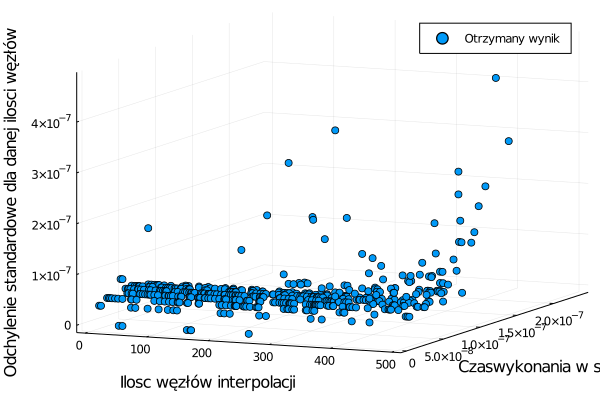

In [474]:
scatter(gdf.amount,gdf.timesPolynomial_mean,gdf.timesPolynomial_std,label = "Otrzymany wynik",xlabel = "Ilosc węzłów interpolacji",ylabel = "Czaswykonania w s",zlabel = "Odchylenie standardowe dla danej ilosci węzłów")

### Rezultaty dla czasu uzyskania wartości

In [476]:
gdf = groupby(Newton,:amount)
gdf = combine(gdf,:timesValues => mean,:timesValues => std)

,amount,timesValues_mean,timesValues_std
,Float64,Float64,Float64
1,1.0,1.1099e-6,2.87848e-6
2,2.0,1.59e-6,4.15143e-6
3,3.0,3.5e-7,8.49837e-8
4,4.0,6.599e-7,2.36484e-7
5,5.0,9.6e-7,1.95506e-7
6,6.0,1.1899e-6,2.68614e-7
7,7.0,8.801e-7,1.13549e-7
8,8.0,9.899e-7,2.02424e-7
9,9.0,1.4e-6,3.3665e-7


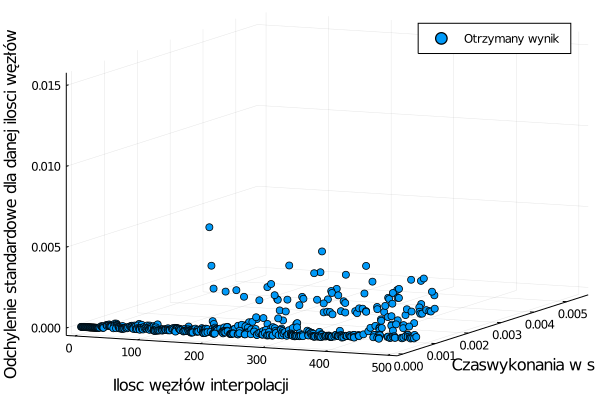

In [477]:
scatter(gdf.amount,gdf.timesValues_mean,gdf.timesValues_std,label = "Otrzymany wynik",xlabel = "Ilosc węzłów interpolacji",ylabel = "Czaswykonania w s",zlabel = "Odchylenie standardowe dla danej ilosci węzłów")

## Osiągnięte rezultaty dla wielomianu Lagrange'a

In [403]:
Lagr = DataFrame(amount = amount,times = times)

,amount,times
,Float64,Float64
1,1.0,0.0
2,1.0,1.0e-7
3,1.0,0.0
4,1.0,1.0e-7
5,1.0,0.0
6,1.0,1.0e-7
7,1.0,1.0e-7
8,1.0,0.0
9,1.0,0.0


In [404]:
gdf = groupby(Lagr,:amount) 
gdf = combine(gdf,:times => mean,:times => std)

,amount,times_mean,times_std
,Float64,Float64,Float64
1,1.0,4.0e-8,5.16398e-8
2,2.0,1.0e-8,3.16228e-8
3,3.0,3.0e-8,4.83046e-8
4,4.0,1.0e-8,3.16228e-8
5,5.0,4.0e-8,5.16398e-8
6,6.0,3.0e-8,4.83046e-8
7,7.0,2.0e-8,4.21637e-8
8,8.0,2.0e-8,4.21637e-8
9,9.0,1.0e-8,3.16228e-8


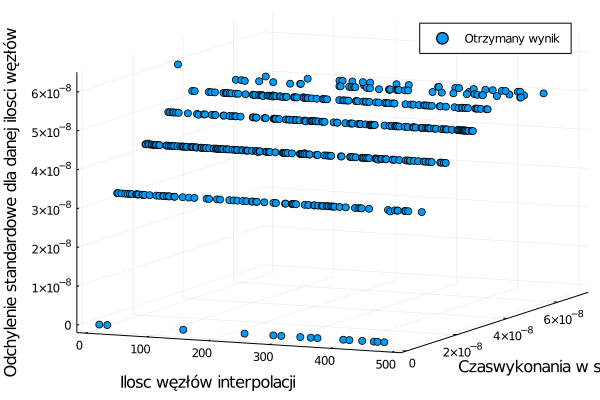

In [457]:
scatter(gdf.amount,gdf.times_mean,gdf.times_std,label = "Otrzymany wynik",xlabel = "Ilosc węzłów interpolacji",ylabel = "Czaswykonania w s",zlabel = "Odchylenie standardowe dla danej ilosci węzłów")

## Algorytm Nevilla


In [405]:
function neville(xs,ys,x)
    n = length(xs)
    q = zeros(n,n)
    
    for i in 1:n
        q[i,1] = ys[i]
    end
    for i in 2:n
        for j in 2:i
            q[i,j] = ((x - xs[i-j+1])*q[i,j-1] - (x-xs[i])*q[i-1,j-1])/(xs[i] - xs[i-j+1])
        end
    end
    res = q[n,n]
    return res
end

neville (generic function with 1 method)

In [531]:
#Sprawdzenie otrzymywanych wartosci dla interpolacji Lagrange'a
X = [rand() for i in 1:100]
Y = [rand() for i in 1:100]
L = LagrangeInterpolation(X,Y)
for i in 1:100
    if(neville(X,Y,i)!=L(i))
        println(neville(X,Y,i),L(i))
        println("Blad")
        break
    end
end

-4.6997501278916695e30-4.699750127849133e30
Blad


## Efekt Rungego i wykorzystanie funkcji sklejanych

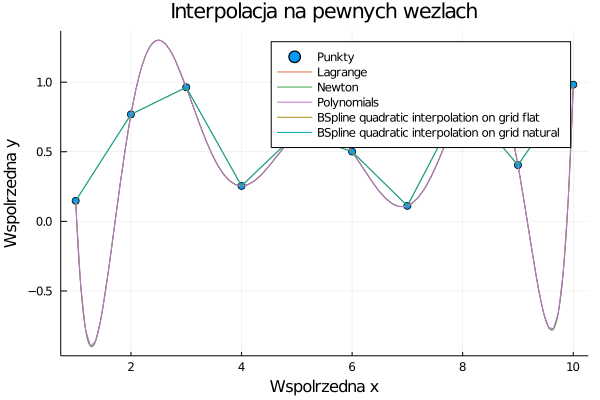

In [407]:
itp = interpolate(B, BSpline(Cubic(Flat(OnGrid()))))
ysf3=[itp(x) for x in A]
plot!(A,ysf3, label="BSpline quadratic interpolation on grid flat")
itp = interpolate(B, BSpline(Cubic(Natural(OnGrid()))))
ysf3=[itp(x) for x in A]
plot!(A,ysf3, label="BSpline quadratic interpolation on grid natural")

Efekt Rungego opisuję sytuację pogorszenia jakości interpolacji wraz ze zwiększaniem się ilości węzłów interpolacji. Pogorszenie jakości można szczególnie zobaczyć na końcowych węzłach interpolacji, gdzie występuje tworzenie się znacznych odkształceń w porównianiu z pozostałymi węzłami. Poniżej znajdują się interpolacje za pomocą wielomianu Lagrange'a dla coraz większej ilości węzłow w celu pokazania jak jakość interpolacji coraz bardziej ulega degradacji.

In [410]:
M = 1:1:20
N = [rand() for x in M]
L = LagrangeInterpolation(M,N)

(::var"#Lagrange#125"{StepRange{Int64,Int64},Array{Float64,1}}) (generic function with 1 method)

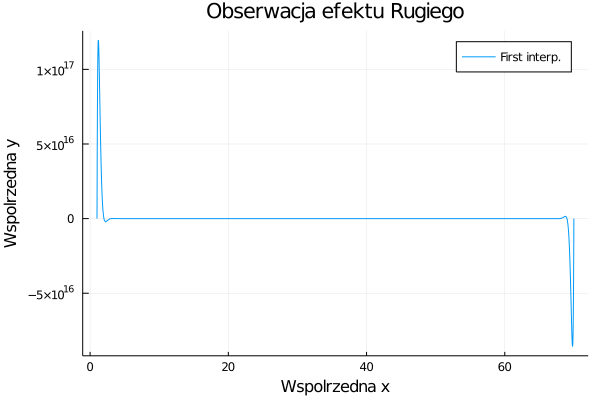

In [424]:
plot(L,extrema(M)...,label = "First interp.",xlabel = "Wspolrzedna x",ylabel = "Wspolrzedna y",title = "Obserwacja efektu Rugiego")

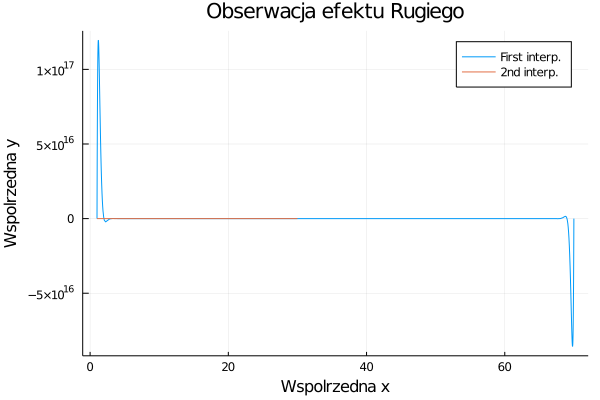

In [425]:
M = 1:1:30
N = [rand() for x in M]
L = LagrangeInterpolation(M,N)
plot!(L,extrema(M)...,label = "2nd interp.",xlabel = "Wspolrzedna x",ylabel = "Wspolrzedna y",title = "Obserwacja efektu Rugiego")

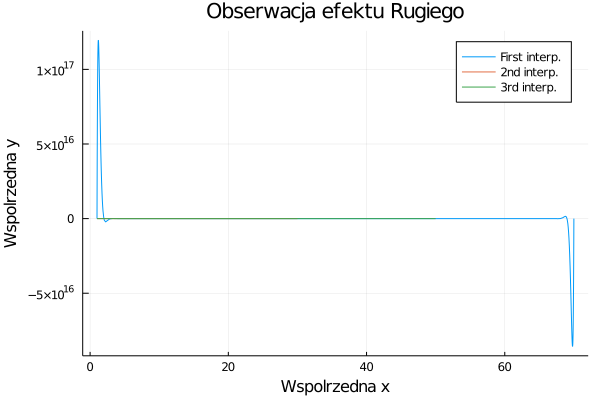

In [426]:
M = 1:1:50
N = [rand() for x in M]
L = LagrangeInterpolation(M,N)
plot!(L,extrema(M)...,label = "3rd interp.",xlabel = "Wspolrzedna x",ylabel = "Wspolrzedna y",title = "Obserwacja efektu Rugiego")

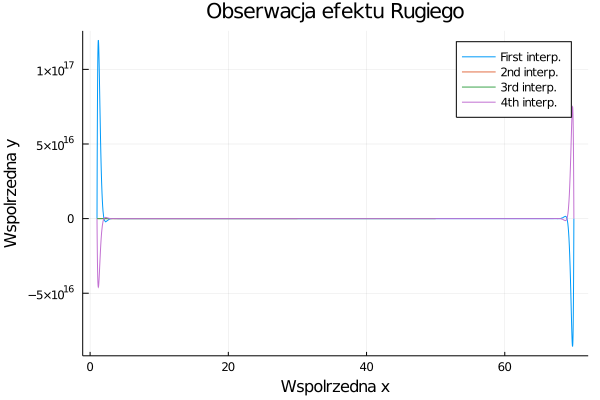

In [427]:
M = 1:1:70
N = [rand() for x in M]
L = LagrangeInterpolation(M,N)
plot!(L,extrema(M)...,label = "4th interp.",xlabel = "Wspolrzedna x",ylabel = "Wspolrzedna y",title = "Obserwacja efektu Rugiego")

Jak można zauważyć efekt Rungego jest zauważalny. Wraz ze wzrostem liczby węzłów interpolacji pogarsza się jakość interpolacj. Im więcej punktów interpolacji bierzemy pod uwagę, bym większe odkształcenia występują na końcach węzłów. Wielkość takich odształceń ulega powiększeniu wraz ze zwiększeniem ilości węzłów interpolacji.